In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('bank-full.csv', sep=';')

In [2]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
df['target'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)

In [4]:
df.drop('y', axis=1, inplace=True)

In [5]:
df.drop(['job', 'marital', 'default'], axis=1, inplace=True)

In [6]:
df.head()

,age,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,target
0,58,tertiary,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,secondary,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,secondary,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,unknown,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


In [7]:
df.target.value_counts()

0    39922
1     5289
Name: target, dtype: int64

In [8]:
from sklearn import preprocessing
from collections import defaultdict
d = defaultdict(preprocessing.LabelEncoder)

# Encoding the categorical variable
fit = df.select_dtypes(include=['object']).fillna('NA').apply(lambda x: d[x.name].fit_transform(x))

#Convert the categorical columns based on encoding
for i in list(d.keys()):
    df[i] = d[i].transform(df[i].fillna('NA'))

In [9]:
features = df[df.columns.difference(['target'])]
labels = df['target']

In [10]:
df.head()

,age,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,target
0,58,2,2143,1,0,2,5,8,261,1,-1,0,3,0
1,44,1,29,1,0,2,5,8,151,1,-1,0,3,0
2,33,1,2,1,1,2,5,8,76,1,-1,0,3,0
3,47,3,1506,1,0,2,5,8,92,1,-1,0,3,0
4,33,3,1,0,0,2,5,8,198,1,-1,0,3,0


In [11]:
from xverse.ensemble import VotingSelector

selector = VotingSelector()

In [12]:
selector.fit(features, labels)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

VotingSelector(exclude_features=None, feature_names='all',
               handle_category='woe', minimum_votes=0, no_of_features=6,
               numerical_missing_values='median',
               selection_techniques=['WOE', 'RF', 'RFE', 'ETC', 'CS', 'L_ONE'])

In [16]:
selector.feature_votes_

,Variable_Name,Information_Value,Random_Forest,Recursive_Feature_Elimination,Extra_Trees,Chi_Square,L_One,Votes
0,duration,1,1,0,1,1,0,5
1,poutcome,1,1,0,0,1,1,5
2,contact,1,0,1,0,1,1,5
4,housing,1,0,1,0,1,1,5
8,campaign,0,0,1,1,0,1,4
9,loan,0,0,1,0,1,1,4
3,pdays,1,0,0,0,1,0,3
5,previous,1,0,1,0,0,0,3
6,month,0,1,0,1,0,0,3
7,balance,0,1,0,1,0,0,3


In [17]:
features_selected = list(selector.feature_votes_[selector.feature_votes_['Votes'] > 2]['Variable_Name'])

In [18]:
features_selected

['duration',
 'poutcome',
 'contact',
 'housing',
 'campaign',
 'loan',
 'pdays',
 'previous',
 'month',
 'balance',
 'education',
 'age',
 'day']

In [19]:
features = features[features_selected]

# Build Model

In [20]:
from sklearn.model_selection import train_test_split

features_train, features_test, label_train, label_test = train_test_split(features, labels, test_size = 0.3)

In [21]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=20, max_depth=5)

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

0.8970518532562328 0.8908139191978768 0.9054249208421162 0.8988237442175466


In [22]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,20544,404
1,1216,26


In [23]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,3762,70
1,162,1


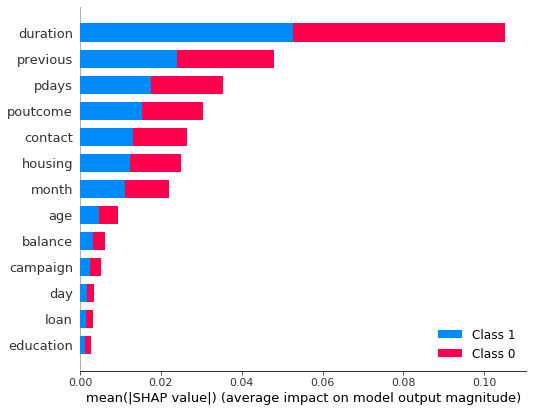

In [24]:
import shap
shap_values = shap.TreeExplainer(clf).shap_values(features_train)
shap.summary_plot(shap_values, features_train, plot_type="bar")

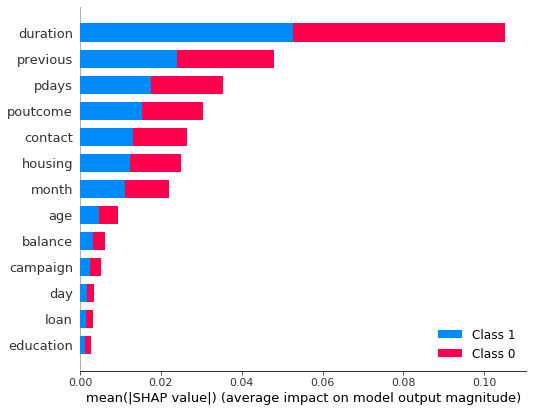

In [25]:
import matplotlib.pyplot as plt
f = plt.figure()
shap.summary_plot(shap_values, features_test)

In [33]:
import shap

def explain_model_prediction(data):
    # Create object that can calculate shap values
    explainer = shap.TreeExplainer(clf)
    # Calculate Shap values
    shap_values = explainer.shap_values(data)
    p = shap.force_plot(explainer.expected_value[1], shap_values[1], data)
    return p

In [34]:
p = explain_model_prediction(features_train.iloc[2])
p

In [95]:
import pickle

obj = [d, features_selected, clf, explainer]

with open('score_objects.pkl', 'wb') as handle:
    pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [29]:
features_selected

['duration',
 'poutcome',
 'contact',
 'housing',
 'campaign',
 'loan',
 'pdays',
 'previous',
 'month',
 'balance',
 'education',
 'age',
 'day']

# Not required to viewed here after. Some notes for testing purpose

In [40]:
features_train.columns

Index(['duration', 'poutcome', 'contact', 'housing', 'campaign', 'loan',
       'pdays', 'previous', 'month', 'balance', 'education', 'age', 'day'],
      dtype='object')

In [42]:
with open('pythonapi/score_objects.pkl', 'rb') as handle:
    d, features_selected, clf, explainer = pickle.load(handle)

In [46]:
d

defaultdict(sklearn.preprocessing._label.LabelEncoder,
            {'education': LabelEncoder(),
             'housing': LabelEncoder(),
             'loan': LabelEncoder(),
             'contact': LabelEncoder(),
             'month': LabelEncoder(),
             'poutcome': LabelEncoder()})

In [59]:
import json
diction = {"age": 18, 
            "balance": -10000, 
            "campaign": 1, "contact": 0, "day": 19, "duration": 0, "education": 2, 
            "housing": 1, "loan": 1, "month": 10, "pdays": -1, "poutcome": 2, "previous": 0}

In [62]:
x = pd.DataFrame([diction])

In [63]:
x = x[features_selected]

In [92]:
clf.predict_proba(x)[:,1][0]

0.2403694668176844

In [93]:
record_no = 5
#x = features_train.iloc[[record_no]]
print(clf.predict(x)[0], clf.predict_proba(x)[:,1][0])
p = explain_model_prediction(x)
p

0 0.2403694668176844


In [108]:
shap_interaction_values = shap.TreeExplainer(clf).shap_interaction_values(x)

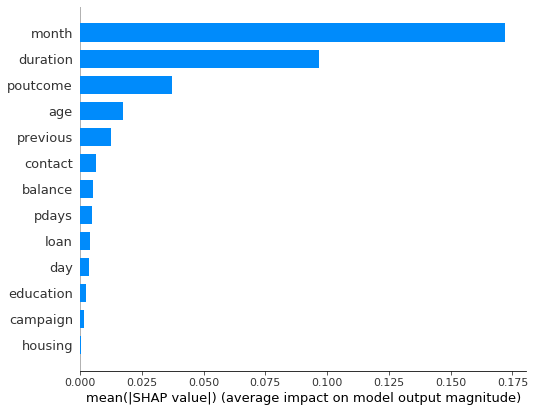

In [115]:
shap_values = explainer.shap_values(x)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], x, plot_type='bar')

In [117]:
shap_values = explainer.shap_values(x)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x, y)
ax2.plot(x, -y)

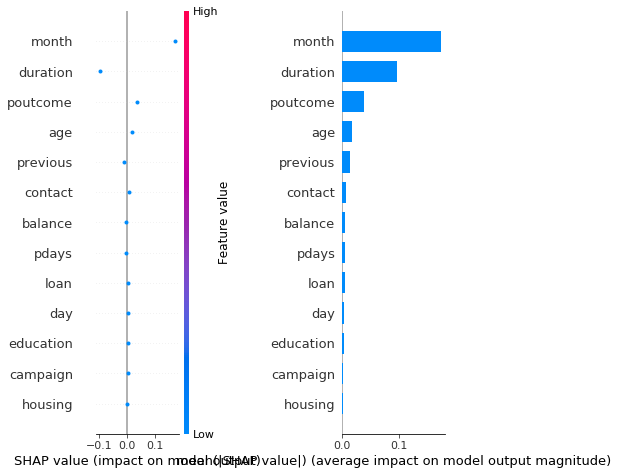

In [130]:
plt.subplot(1,2,1)
shap.summary_plot(shap_values[1], x, show=False)
plt.subplot(1,2,2)
shap.summary_plot(shap_values[1], x, plot_type='bar', show=False)
plt.tight_layout()
plt.show()